In [1]:
import os
from raphtory import Graph

# Specify the file path
binecode_path = "C:/ms_bincode/Graph_3"

# Load the file
if os.path.isfile(binecode_path):
    g = Graph.load_from_file(binecode_path)
    print(g)
else:
    print(f"File does not exist: {binecode_path}")

Graph(number_of_edges=97252, number_of_vertices=26533, number_of_temporal_edges=159288593, earliest_time="7200000", latest_time="10799999")


In [3]:
from raphtory import algorithms as rp
from raphtory import Graph

start_time = 10200000 # Minute 170
end_time = 10200000 +60000 # Minute 171

g_spike_spike = g.window(start_time, end_time)
print(g_spike_spike)

Graph(number_of_edges=34081, number_of_vertices=12182, number_of_temporal_edges=3273937, earliest_time="10200000", latest_time="10259999")


In [4]:
import numpy as np

def transfor_into_adjacency_matrix(graph):
    node_index = {node_name: i for i, node_name in enumerate(list(graph.vertices.name))}
    adjacency_matrix = np.zeros((len(node_index), len(node_index)), dtype=int)
    for edge in graph.edges:
        src_index = node_index[edge.src.name]
        dst_index = node_index[edge.dst.name]
        adjacency_matrix[src_index, dst_index] = 1
    return adjacency_matrix

# Turn one minute graph into adjacency matrices

In [11]:
A_dict = {}
i = 0

# For each minute segment, generate an adjacency matrix and store it.
for windowed_graph in g_spike_spike.rolling(window=30000):
    i +=1
    minute_graph_segment = windowed_graph
    adjacency_matrix = transfor_into_adjacency_matrix(minute_graph_segment)
    A_dict[i] = adjacency_matrix

In [17]:
# Step 1: Identify all unique vertices
all_vertices = set()
for windowed_graph in g_spike_spike.rolling(window=30000):
    for vertex in windowed_graph.vertices:
        all_vertices.add(vertex.name)

# Create a global index for all vertices
node_index = {node_name: i for i, node_name in enumerate(list(all_vertices))}

def transform_into_adjacency_matrix(graph, node_index):
    """Generates an adjacency matrix for the graph using a global node index."""
    adjacency_matrix = np.zeros((len(node_index), len(node_index)), dtype=int)
    for edge in graph.edges:
        src_index = node_index[edge.src.name]
        dst_index = node_index[edge.dst.name]
        adjacency_matrix[src_index, dst_index] = 1
    return adjacency_matrix

A_dict = {}
i = 0

# Step 2: Generate adjacency matrices with consistent dimensions
for windowed_graph in g_spike_spike.rolling(window=30000):
    i += 1
    minute_graph_segment = windowed_graph
    adjacency_matrix = transform_into_adjacency_matrix(minute_graph_segment, node_index)
    A_dict[i] = adjacency_matrix

In [19]:
print(A_dict)

{1: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 2: array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])}


In [5]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb  6 10:52:20 2023

@author: Giles
https://github.com/gwinch97/pystates
"""

import numpy as np
from tqdm import tqdm,trange
from scipy.sparse.csgraph import laplacian



def claplacian(M,norm=True):
    if norm == True:
        L = np.diag(sum(M)) - M
        v = 1./np.sqrt(sum(M))
        return np.diag(v) * L * np.diag(v)
    else:
        return np.diag(sum(M)) - M
    
def eigenspectrum(L):
    eigvals = np.real(np.linalg.eig(L)[0])
    return -np.sort(-eigvals)

def all_spectrums(A_dict,norm=True):
    dict_keys = list(A_dict.keys())
    eigenspectrums = np.zeros((np.shape(A_dict[dict_keys[0]])[0], len(dict_keys)))
    i = 0
    for key in tqdm(dict_keys):
        L = laplacian(A_dict[key],normed=norm)
        eigenspectrums[:,i] = eigenspectrum(L)
        i+=1
    return eigenspectrums
    
def snapshot_dist(eigenspectrums,norm=True):
    # Old implementation, now use scipy.spatial.distance.cdist
    N = np.shape(eigenspectrums)[1]
    dist = np.zeros((N,N))
    for i in trange(N):
        for j in range(N):
            dist[i,j] = np.sqrt(np.sum(np.power((eigenspectrums[:,i]-eigenspectrums[:,j]),2)))
            if norm == True:
                if max(max(eigenspectrums[:,i]),max(eigenspectrums[:,j])) > 1e-10:
                    dist[i,j] = dist[i,j]/np.sqrt(max((np.sum(np.power(eigenspectrums[:,i],2))),(np.sum(np.power(eigenspectrums[:,j],2)))))
                else:
                    dist[i,j] = 0
                    
    return dist  

In [20]:
from scipy.spatial import distance
import pickle
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import random
from random import randint

eigenspectrums = all_spectrums(A_dict,norm=True).T

100%|██████████| 2/2 [01:23<00:00, 41.96s/it]


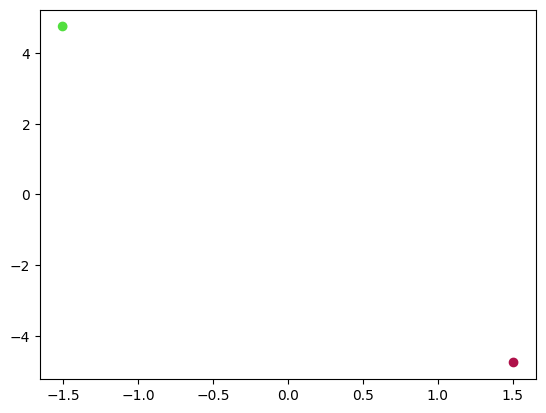

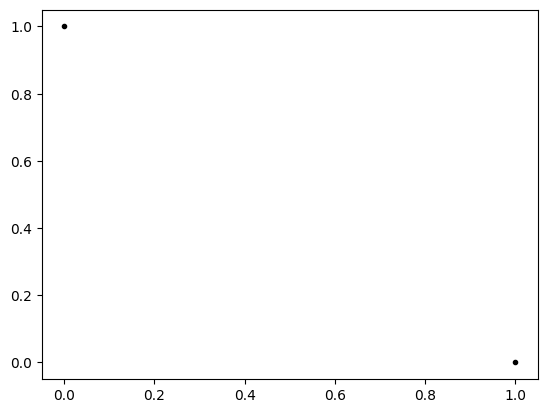

In [22]:
dist2 = distance.cdist(eigenspectrums,eigenspectrums,'euclidean')
mds = MDS(n_components=2,dissimilarity='precomputed',random_state=0)
results = mds.fit(dist2)
coords = results.embedding_

agg = AgglomerativeClustering().fit(coords)
labels = agg.labels_
colours = []
for i in range(np.max(labels)+1):
    colours.append('#%06X' % randint(0, 0xFFFFFF))
cmap=[]
for i in labels:
    cmap.append(colours[i])
plt.figure()
plt.scatter(coords[:,0],coords[:,1],c=cmap)

plt.figure()
plt.plot(labels,'k.')

In [13]:
# -*- coding: utf-8 -*-
"""
Created on Wed Feb 14 14:29:54 2024

@author: Giles
https://github.com/gwinch97/pystates
"""

from scipy.spatial import distance
import pickle
from sklearn.manifold import MDS
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import random
from random import randint

def LMDS(D, lands, dim):
	Dl = D[:,lands]
	n = len(Dl)

	# Centering matrix
	H = - np.ones((n, n))/n
	np.fill_diagonal(H,1-1/n)
	# YY^T
	H = -H.dot(Dl**2).dot(H)/2

	# Diagonalize
	evals, evecs = np.linalg.eigh(H)

	# Sort by eigenvalue in descending order
	idx   = np.argsort(evals)[::-1]
	evals = evals[idx]
	evecs = evecs[:,idx]

	# Compute the coordinates using positive-eigenvalued components only
	w, = np.where(evals > 0)
	if dim:
		arr = evals
		w = arr.argsort()[-dim:][::-1]
		if np.any(evals[w]<0):
			print('Error: Not enough positive eigenvalues for the selected dim.')
			return []
	if w.size==0:
		print('Error: matrix is negative definite.')
		return []

	V = evecs[:,w]
	N = D.shape[1]
	Lh = V.dot(np.diag(1./np.sqrt(evals[w]))).T
	Dm = D - np.tile(np.mean(Dl,axis=1),(N, 1)).T
	dim = w.size
	X = -Lh.dot(Dm)/2.
	X -= np.tile(np.mean(X,axis=1),(N, 1)).T

	_, evecs = sp.linalg.eigh(X.dot(X.T))

	return (evecs[:,::-1].T.dot(X)).T

# Example usage
with open("corrs.pkl","rb") as f:
    corr_dict = pickle.load(f)

eigenspectrums = all_spectrums(corr_dict,norm=True).T

# Using old distance implementation - note this is much slower with the same result
dist1 = snapshot_dist(eigenspectrums.T,norm=False)
mds = MDS(n_components=2,dissimilarity='precomputed',random_state=0)
results = mds.fit(dist1)
coords = results.embedding_

agg = AgglomerativeClustering().fit(coords)
labels = agg.labels_
colours = []
for i in range(np.max(labels)+1):
    colours.append('#%06X' % randint(0, 0xFFFFFF))
cmap=[]
for i in labels:
    cmap.append(colours[i])
plt.figure()
plt.scatter(coords[:,0],coords[:,1],c=cmap)

plt.figure()
plt.plot(labels,'k.')

# Using new distance implementation with MDS
dist2 = distance.cdist(eigenspectrums,eigenspectrums,'euclidean')
mds = MDS(n_components=2,dissimilarity='precomputed',random_state=0)
results = mds.fit(dist1)
coords = results.embedding_

agg = AgglomerativeClustering().fit(coords)
labels = agg.labels_
colours = []
for i in range(np.max(labels)+1):
    colours.append('#%06X' % randint(0, 0xFFFFFF))
cmap=[]
for i in labels:
    cmap.append(colours[i])
plt.figure()
plt.scatter(coords[:,0],coords[:,1],c=cmap)

plt.figure()
plt.plot(labels,'k.')

# Example using LMDS instead of MDS
landmarks = random.sample(range(0,eigenspectrums.shape[0],1),100)
dist3 = distance.cdist(eigenspectrums[landmarks,:],eigenspectrums,'euclidean')
coords = LMDS(dist3,landmarks,2)

agg = AgglomerativeClustering().fit(coords)
labels = agg.labels_
colours = []
for i in range(np.max(labels)+1):
    colours.append('#%06X' % randint(0, 0xFFFFFF))
cmap=[]
for i in labels:
    cmap.append(colours[i])
plt.figure()
plt.scatter(coords[:,0],coords[:,1],c=cmap)

plt.figure()
plt.plot(labels,'k.')


KeyboardInterrupt: 